# Meridian MMM

Relevant imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

import warnings
warnings.simplefilter("ignore")

Mapping column names to variable types

In [2]:
coord_to_columns = load.CoordToColumns(
    time='date_week',
    controls=['c1', 'c2', 'c3'],
    kpi='y',
    media=['x1', 'x2', 'x3', 'x4'],
    media_spend=['x1', 'x2', 'x3', 'x4'],
)

correct_media_to_channel = {'x1': 'x1', 'x2': 'x2', 'x3': 'x3', 'x4': 'x4'}

Loading the data and setting coordinates

In [3]:
loader = load.CsvDataLoader(
    csv_path=f'/Users/jakepiekarski/Documents/meridian-blog/model_data.csv',
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_to_channel,
)
data = loader.load()

Model Specification

As this is a national model:

- $\eta = 0$ for all channels. This parameter represents the global param for the beta prior variance across all geo's.
- $\xi = 0$ for all controls. This parameter represents the global variance prior for gamma variance across all geo's
- $\beta^{[M]}_{g,i} = \beta^{[M]}_{i}$ for all channels $i$
- $\gamma^{[C]}_{g,i} = \gamma^{[C]}_{i}$ for all controls $i$
- $\tau_g = 0$

So the model becomes:

$$
y_{g,t} = \mu_t 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{HillAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_i, slope^{[M]}_i \right) + \epsilon_{t}
$$


The default configuration has been used. That is:

- $\beta^{[M]}_i \sim $ LogNormal(5)
- $\gamma^{[C]} \sim $ Normal(0,5)
- $\alpha^{[M]} \sim $ Uniform(0,1)
- $ec^{[M]} \sim $ TruncatedNormal(l = 0.1, u = 10, $\mu$ = 0.8, $\sigma$ = 0.8)
- $slope^{[M]} \sim $ Determinstic(1), meaning slope = 1
- $\sigma \sim $ HalfNormal(5) 

In [4]:
model_spec = spec.ModelSpec(
    prior=prior_distribution.PriorDistribution(),
    media_effects_dist='log_normal',
    hill_before_adstock=False,
    max_lag=12,
    unique_sigma_for_each_geo=False,
    paid_media_prior_type='coefficient',
    roi_calibration_period=None,
    rf_roi_calibration_period=None,
    knots=None,
    baseline_geo=None,
    holdout_id=None,
    control_population_scaling_id=None,
)

Run the model

In [5]:
meridian = model.Meridian(input_data=data, model_spec=model_spec)
meridian.sample_prior(1000)
meridian.sample_posterior(n_chains=4, n_adapt=1000, n_burnin=500, n_keep=1000)

I0000 00:00:1745594246.357586  550715 service.cc:145] XLA service 0x600000ba9200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745594246.357679  550715 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1745594246.378719  550715 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-25 16:17:44.352443: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745594264.607400  550715 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1745594264.828228  550715 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Quick diagnostic checks

In [6]:
true_count = meridian.inference_data.trace.diverging.sum()
print(f"Number of Divergences: {true_count.values}")

Number of Divergences: 0


In [7]:
max_rhat = az.summary(meridian.inference_data)['r_hat'].max()
print(f"Max rhat: {max_rhat}")

Max rhat: 1.0


In [8]:
rhat_above_1 = (az.summary(meridian.inference_data)['r_hat'] > 1).sum()
print(f"Number of rhat values above 1: {rhat_above_1}")

Number of rhat values above 1: 0


In [9]:
az.summary(meridian.inference_data, var_names = ['alpha_m','beta_m','ec_m','gamma_c','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_m[x1],0.666,0.107,0.455,0.851,0.002,0.001,2715.0,2345.0,1.0
alpha_m[x2],0.122,0.068,0.001,0.235,0.001,0.001,2959.0,1510.0,1.0
alpha_m[x3],0.173,0.053,0.079,0.277,0.001,0.001,2993.0,2320.0,1.0
alpha_m[x4],0.575,0.247,0.101,0.963,0.005,0.003,2791.0,2107.0,1.0
beta_m[x1],2.445,0.522,1.441,3.422,0.010,0.007,2705.0,2666.0,1.0
beta_m[x2],2.303,0.355,1.630,2.932,0.007,0.005,2675.0,2802.0,1.0
beta_m[x3],4.042,0.609,2.945,5.173,0.014,0.010,2097.0,2234.0,1.0
beta_m[x4],0.794,0.427,0.144,1.599,0.010,0.007,1550.0,2431.0,1.0
ec_m[x1],1.634,0.574,0.566,2.694,0.011,0.007,2795.0,2155.0,1.0
ec_m[x2],2.095,0.556,1.030,3.111,0.011,0.008,2605.0,2988.0,1.0


In [10]:
model_diagnostics = visualizer.ModelDiagnostics(meridian)
model_diagnostics.predictive_accuracy_table()

,metric,geo_granularity,value
0,R_Squared,national,0.909992
1,MAPE,national,0.069489
2,wMAPE,national,0.063813


### Parameter recovery 

- Adstock $\alpha^{[M]}$
- Saturation $ec^{[M]}$
- Media $\beta^{[M]}$
- Control $\gamma^{[C]}$

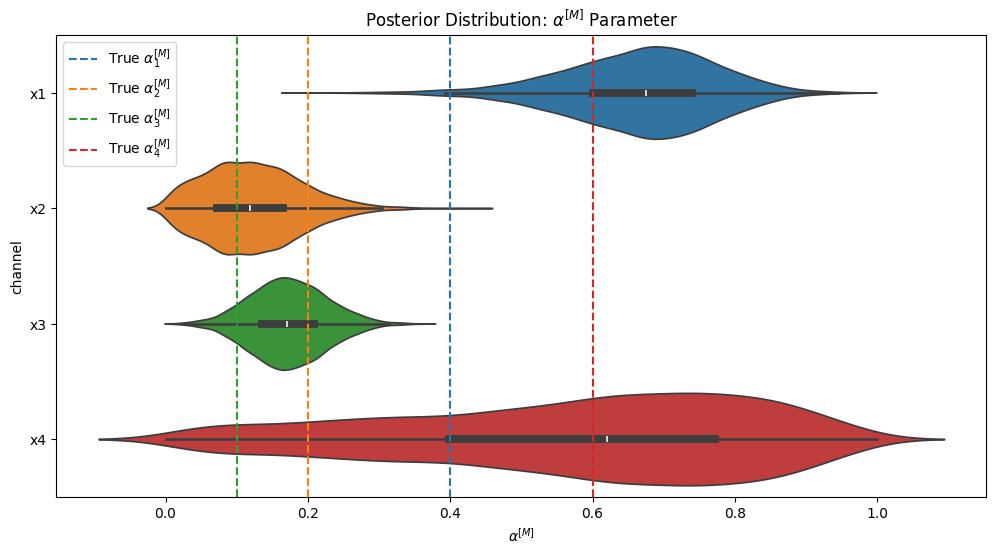

In [11]:
# True alphas
alpha1: float = 0.4
alpha2: float = 0.2
alpha3: float = 0.1
alpha4: float = 0.6

# Estimated alphas
alpha_m_samples_df = pd.DataFrame(data=az.extract(meridian.inference_data, var_names=['alpha_m']).T, columns = meridian.inference_data.posterior.media_channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=alpha_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\alpha^{[M]}$"} Parameter",xlabel=r"$\alpha^{[M]}$",ylabel="channel")
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"True $\alpha^{[M]}_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"True $\alpha^{[M]}_2$")
ax.axvline(x=alpha3, color="C2", linestyle="--", label=r"True $\alpha^{[M]}_3$")
ax.axvline(x=alpha4, color="C3", linestyle="--", label=r"True $\alpha^{[M]}_4$")
ax.legend()
plt.show()

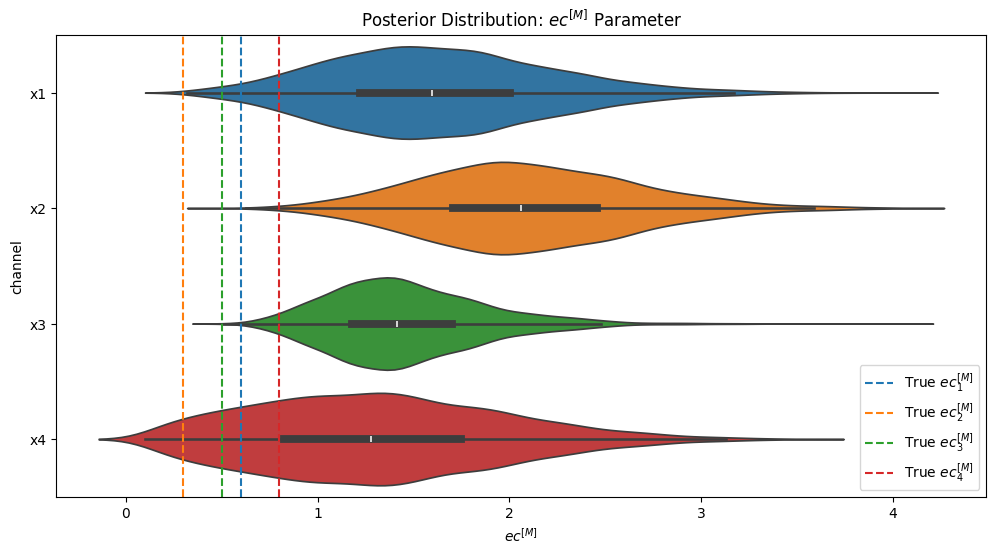

In [12]:
# True ec's
x1_ec, x1_slope = 0.6, 1.0 
x2_ec, x2_slope = 0.3, 1.0
x3_ec, x3_slope = 0.5, 1.0 
x4_ec, x4_slope = 0.8, 1.0

# Estimated ec's
ec_m_samples_df = pd.DataFrame(data=az.extract(meridian.inference_data, var_names=['ec_m']).T, columns = meridian.inference_data.posterior.media_channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=ec_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$ec^{[M]}$"} Parameter",xlabel=r"$ec^{[M]}$",ylabel="channel")
ax.axvline(x=x1_ec, color="C0", linestyle="--", label=r"True $ec^{[M]}_1$")
ax.axvline(x=x2_ec, color="C1", linestyle="--", label=r"True $ec^{[M]}_2$")
ax.axvline(x=x3_ec, color="C2", linestyle="--", label=r"True $ec^{[M]}_3$")
ax.axvline(x=x4_ec, color="C3", linestyle="--", label=r"True $ec^{[M]}_4$")
ax.legend()
plt.show()

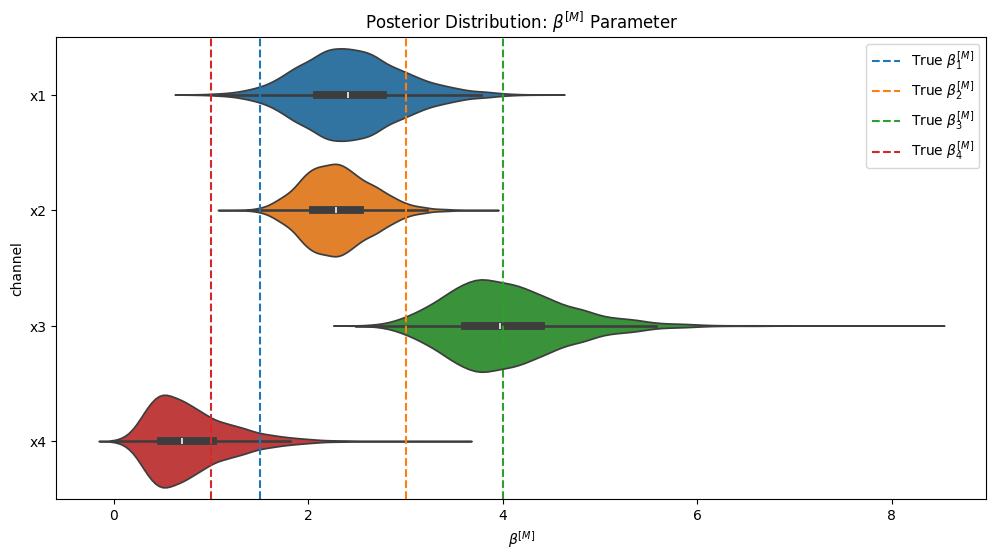

In [13]:
# True beta's
beta_x1 = 1.5
beta_x2 = 3.0
beta_x3 = 4.0
beta_x4 = 1.0

# Estimated betas
beta_m_samples_df = pd.DataFrame(data=az.extract(meridian.inference_data, var_names=['beta_m']).T, columns = meridian.inference_data.posterior.media_channel)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=beta_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\beta^{[M]}$"} Parameter",xlabel=r"$\beta^{[M]}$",ylabel="channel")
ax.axvline(x=beta_x1, color="C0", linestyle="--", label=r"True $\beta^{[M]}_1$")
ax.axvline(x=beta_x2, color="C1", linestyle="--", label=r"True $\beta^{[M]}_2$")
ax.axvline(x=beta_x3, color="C2", linestyle="--", label=r"True $\beta^{[M]}_3$")
ax.axvline(x=beta_x4, color="C3", linestyle="--", label=r"True $\beta^{[M]}_4$")
ax.legend()
plt.show()

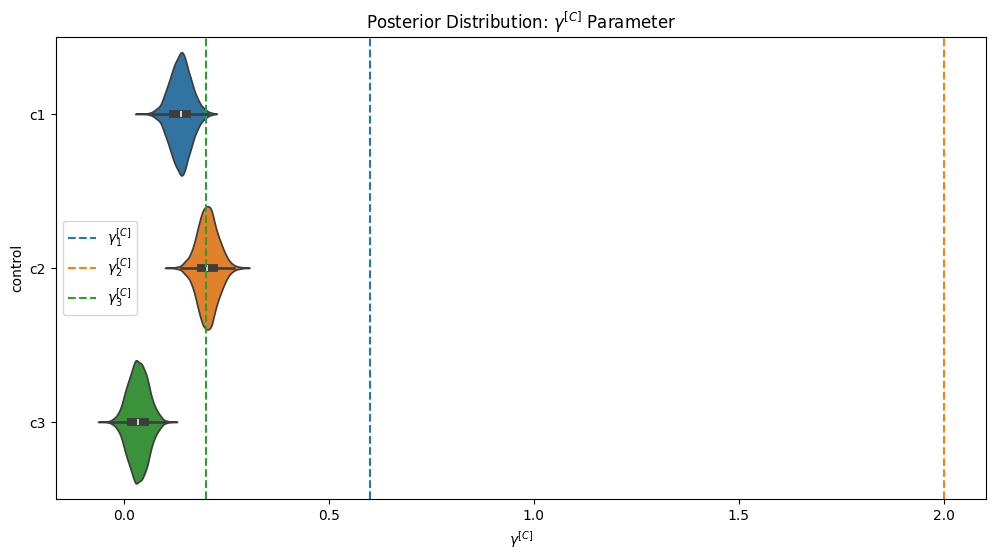

In [14]:
# True gammas
beta_c1 = 0.6
beta_c2 = 2.0
beta_c3 = 0.2

# Estimated gammas
gamma_m_samples_df = pd.DataFrame(data=az.extract(meridian.inference_data, var_names=['gamma_c']).T, columns = meridian.inference_data.posterior.control_variable)

fig, ax = plt.subplots(figsize = (12,6))
sns.violinplot(data=gamma_m_samples_df, orient="h", ax=ax)
ax.set(title=f"Posterior Distribution: {r"$\gamma^{[C]}$"} Parameter",xlabel=r"$\gamma^{[C]}$",ylabel="control")
ax.axvline(x=beta_c1, color="C0", linestyle="--", label=r"$\gamma^{[C]}_{1}$")
ax.axvline(x=beta_c2, color="C1", linestyle="--", label=r"$\gamma^{[C]}_{2}$")
ax.axvline(x=beta_c3, color="C2", linestyle="--", label=r"$\gamma^{[C]}_{3}$")
ax.legend()
plt.show()

### Insights recovery

- Contributions over time
- ROAS

**Note:** There is no functionality to extract the full sales attribution over time. You can extract channels and baseline, but to extract controls, you have to derive the contributions directly.

In [17]:
# Fetch contributions over time
model_analysis = analyzer.Analyzer(meridian)
incremental_df = model_analysis.incremental_outcome(aggregate_times=False, use_kpi=True)

mean_contributions = tf.reduce_mean(incremental_df, axis=[0,1])

lower_bound = tfp.stats.percentile(incremental_df, 3, axis=[0, 1])  
upper_bound = tfp.stats.percentile(incremental_df, 97, axis=[0, 1]) 

mean_contribution_df = pd.DataFrame(tf.reduce_mean(incremental_df, axis=[0,1]).numpy())
mean_contribution_df.columns = data.media.coords['media_channel'].values
mean_contribution_df['date_week'] = data.time

lower_contribution_df = pd.DataFrame(tfp.stats.percentile(incremental_df, 5, axis=[0, 1]).numpy())
lower_contribution_df.columns = data.media.coords['media_channel'].values
lower_contribution_df['date_week'] = data.time

upper_contribution_df = pd.DataFrame(tfp.stats.percentile(incremental_df, 95, axis=[0, 1]).numpy())
upper_contribution_df.columns = data.media.coords['media_channel'].values
upper_contribution_df['date_week'] = data.time

In [18]:
# Reading in true contributions
true_contributions = pd.read_csv("/Users/jakepiekarski/Documents/meridian-blog/true_contribution_data_over_time.csv")

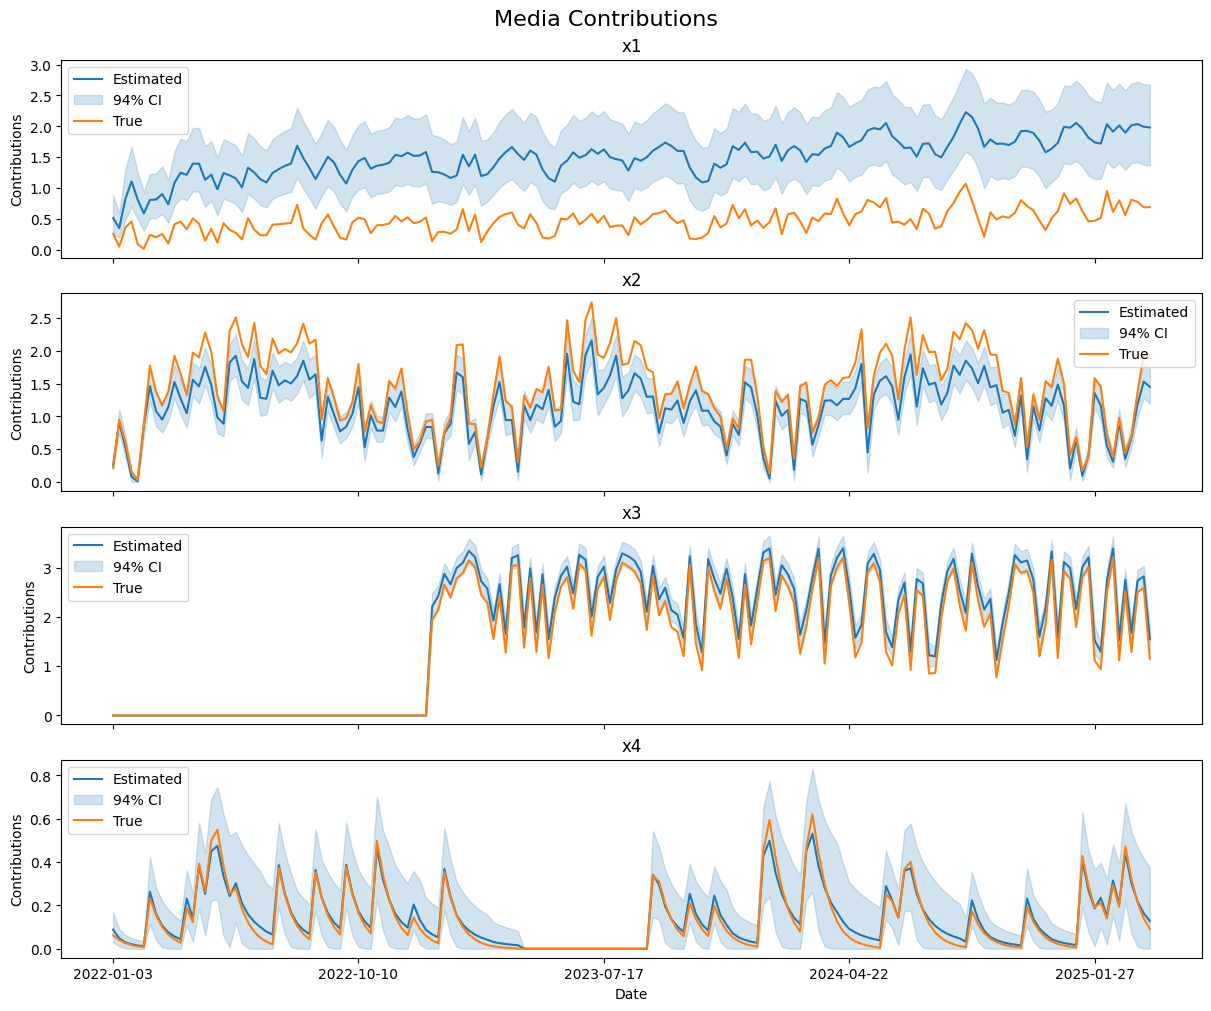

In [19]:
fig, ax = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 10), sharex=True, layout="constrained"
)

sns.lineplot(x="date_week", y="x1", data=mean_contribution_df, color="C0", ax=ax[0], label="Estimated")
ax[0].fill_between(
    mean_contribution_df["date_week"], 
    lower_contribution_df["x1"],  # Lower bound column
    upper_contribution_df["x1"],  # Upper bound column
    color="C0", alpha=0.2, label="94% CI"  # Adjust transparency
)
sns.lineplot(x="date_week", y="x1_contribution", data=true_contributions, color="C1", ax=ax[0], label="True")
ax[0].set(title="x1")

sns.lineplot(x="date_week", y="x2", data=mean_contribution_df, color="C0", ax=ax[1], label="Estimated")
ax[1].fill_between(
    mean_contribution_df["date_week"], 
    lower_contribution_df["x2"],  # Lower bound column
    upper_contribution_df["x2"],  # Upper bound column
    color="C0", alpha=0.2, label="94% CI"  # Adjust transparency
)
sns.lineplot(x="date_week", y="x2_contribution", data=true_contributions, color="C1", ax=ax[1], label="True")
ax[1].set(title="x2")

sns.lineplot(x="date_week", y="x3", data=mean_contribution_df, color="C0", ax=ax[2], label="Estimated")
ax[2].fill_between(
    mean_contribution_df["date_week"], 
    lower_contribution_df["x3"],  # Lower bound column
    upper_contribution_df["x3"],  # Upper bound column
    color="C0", alpha=0.2, label="94% CI"  # Adjust transparency
)
sns.lineplot(x="date_week", y="x3_contribution", data=true_contributions, color="C1", ax=ax[2], label="True")
ax[2].set(title="x3")

sns.lineplot(x="date_week", y="x4", data=mean_contribution_df, color="C0", ax=ax[3], label="Estimated")
ax[3].fill_between(
    mean_contribution_df["date_week"], 
    lower_contribution_df["x4"],  # Lower bound column
    upper_contribution_df["x4"],  # Upper bound column
    color="C0", alpha=0.2, label="94% CI"  # Adjust transparency
)
sns.lineplot(x="date_week", y="x4_contribution", data=true_contributions, color="C1", ax=ax[3], label="True")
ax[3].set(title="x4")

for a in ax.flat:
    a.set(xlabel="Date", ylabel="Contributions")
    a.legend()
    a.xaxis.set_major_locator(plt.MaxNLocator(5))  # Spread out the dates more

fig.suptitle("Media Contributions", fontsize=16)
plt.show()

In [20]:
meridian_roas = mean_contribution_df.sum(axis = 0).drop(['date_week'])/data.media.sum(axis = (0,1)).to_series()

In [21]:
true_contributions_renamed = true_contributions.rename(columns={
    "x1_contribution": "x1",
    "x2_contribution": "x2",
    "x3_contribution": "x3",
    "x4_contribution": "x4"
})

true_roas = true_contributions_renamed[["x1", "x2", "x3", "x4"]].sum()/data.media.sum(axis = (0,1)).to_series()

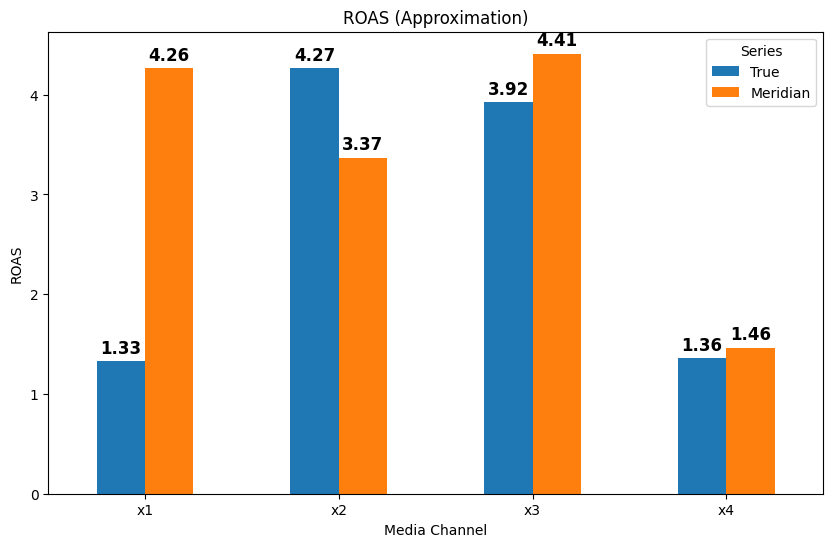

In [22]:
roas = df = pd.DataFrame({"True": true_roas, "Meridian": meridian_roas})

# Create DataFrame
roas = pd.DataFrame({"True": true_roas, "Meridian": meridian_roas})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar chart
roas.plot(kind="bar", ax=ax, color=["C0", "C1"])

# Add title and labels
ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS")

# Add values above bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, fontweight="bold", padding=3)

# Show plot
plt.xticks(rotation=0)  # Ensure x-axis labels are readable
plt.legend(title="Series")
plt.show()

In [23]:
summarizer = summarizer.Summarizer(meridian)

In [28]:
filepath = '/Users/jakepiekarski/Documents/meridian-blog'
start_date = '2022-10-10'
end_date = '2025-01-27'
summarizer.output_model_results_summary('meridian_output.html',
                                        filepath,
                                        start_date,
                                        end_date)